1. Import Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import math
from datetime import datetime, timedelta, date
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.patches as patches
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import os
from scipy import linalg
from scipy import stats
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from mapping_tickers import *
from mapping_portfolio_downloads import *
from mapping_plot_attributes import theme_style
from utils import *

2. Define Tickers

In [2]:
# tickers = list(etf_tickers.keys())
# tickers = crypto_etf_tickers
# tickers = list(stock_index_tickers.keys())
# tickers = list(volatility_tickers.keys())
# tickers = list(yt_example_tickers.keys())
# tickers = list(djia_components.keys())
# tickers = list(ndx_top30_components.keys())
# tickers = list(magnificent_7_tickers.keys())
# tickers = ['AAPL', 'CSCO', 'MSFT', 'MMM', 'IBM', 'VZ', 'INTC']  # IT tickers in G. Pasini's paper
# tickers = ['AXP', 'GE', 'GS', 'JPM', 'TRV']  # FIN tickers in G. Pasini's paper
# tickers = ['LP25']  # Example in Wurtz p. 35
tickers = ['AAPL']

# Benchmark ticker - will be user's input from dashboard app
tk_market = '^GSPC'  # S&P 500 Index for stocks
# tk_market = 'GBTC'  # Grayscale Bitcoin Trust ETF for cryptos
# tk_market = '^VIX'

3. Define Start and End Dates

In [14]:
# NOTE: These will be user's inputs from the dashboard app. The user should be provided 
# with the first date the data for a chosen ticker is available, which should help with 
# the selection of both the tickers and the start date.
#
# NOTE: 
# 1) A choice for the end date should also be provided in the app, so the user can test
# portfolio's performance during a selected historical period, e.g. during a financial crisis.
# 2) A custom choice of year, month and day should also be provided for both the start and end date

end_date = datetime.today()
hist_years = 1
hist_months = 0
hist_days = 0
start_date = datetime(end_date.year - hist_years, end_date.month - hist_months, end_date.day - hist_days)

# end_date = datetime(2006, 9, 4)    # Wurtz p. 35, example for 'LP25'
# start_date = datetime(2000, 1, 4)  # Wurtz p. 35, example for 'LP25'
print(start_date, end_date)

2023-09-21 00:00:00 2024-09-21 10:39:33.850640


4. Download Adjusted Close Prices and Volumes

In [7]:
# Adjusted Close are more accurate than regular Close because they include dividends and stock splits
df_adj_close = pd.DataFrame()
df_volume = pd.DataFrame()
df_dollar_volume = pd.DataFrame()
for tk in tickers:
    data = yf.download(tk, start=start_date, end=end_date)
    # data = yf.download(tk, period='1d')
    # print(f'{tk}:\t{data.index[0]}\t{data["Adj Close"].values[0]:.8f}\t{data["Volume"].values[0]:.8f}')
    df_adj_close[tk] = data['Adj Close']
    df_volume[tk] = data['Volume']
    df_dollar_volume[tk] = data['Adj Close'] * data['Volume']

# Dropping dates with NaNs now in order to avoid dropping two consecutive dates for each NaN later
# (each log return is based on two consecutive dates, so log returns at both of them would be NaN
# if any of them is NaN)

# Below are checks on when the data starts for any ticker, i.e. when the initial NaNs end.
# E.g. dropping NaNs for etf_tickers shortens the historical period from 3 years to 2.5 years because
# of the missing data for DJIA.

# Check for Adj Close data start. Volume data start together with the prices data,
# so there is no need to check df_volume.

df_adj_close_start = pd.DataFrame(columns=['Adj Close Start Date'])
last_date_tk = df_adj_close.index.max().date()
missing_end_date_tickers = []

for tk in tickers:
    start_date_tk = df_adj_close.index[~df_adj_close[tk].isna()].min().date()
    last_nan_date_tk = df_adj_close.index[df_adj_close[tk].isna()].max().date()
    
    # print(tk, start_date_tk, last_nan_date_tk, end_date.date())

    if (start_date_tk > start_date.date()) & ~pd.isnull(last_nan_date_tk):
        if last_nan_date_tk < start_date_tk:
            df_adj_close_start.loc[tk, 'Adj Close Start Date'] = start_date_tk

    if ~pd.isnull(last_nan_date_tk) & (last_nan_date_tk == end_date.date()):
        missing_end_date_tickers.append(tk)
        
if len(df_adj_close_start) > 0:
    min_start_date_adj_close_tk = df_adj_close_start['Adj Close Start Date'].min()
    print(f'WARNING: Data for these tickers start after the selected start date of {start_date.date()}.')
    for tk in df_adj_close_start.index:
        print(f"\t{tk}:\t{df_adj_close_start.loc[tk, 'Adj Close Start Date']}")
    print(f'The whole portfolio data will be truncated to start at {min_start_date_adj_close_tk}.')
    print(f'Please consider adjusting the start date or removing some tickers if you wish to avoid that.')

if last_date_tk < end_date.date():
    print(f'WARNING: No data available for the selected portfolio tickers at the end date of {end_date.date()}.')
    print(f'The portfolio data will be truncated to end at the latest available date of {last_date_tk}.')
elif len(missing_end_date_tickers) > 0:
    print(f'WARNING: Data for these tickers is missing for the selected end date of {end_date.date()}.')
    print(missing_end_date_tickers)
    print(f'The whole portfolio data will be truncated to end at the latest date containing data for all tickers.')

df_adj_close = df_adj_close.dropna()  
# print(df_adj_close.iloc[-1])
# print(len(df_adj_close))
display(df_adj_close)

df_volumes = df_volume.dropna()
# print(df_volume.iloc[-1])
# print(len(df_volume))

df_dollar_volume = df_dollar_volume.dropna()
# print(df_dollar_volume.iloc[-1])
# print(len(df_dollar_volume))


[*********************100%%**********************]  1 of 1 completed

The portfolio data will be truncated to end at the latest available date of 2024-09-20.


,AAPL
Date,
2023-09-21,173.044495
2023-09-22,173.900131
2023-09-25,175.183578
2023-09-26,171.084549
2023-09-27,169.562332
...,...
2024-09-16,216.320007
2024-09-17,216.789993
2024-09-18,220.690002


In [8]:
# df_adj_close = pd.DataFrame(columns=tickers)
# df_adj_close = pd.read_csv('../data/downloads/LP25.csv', index_col='Date')
# df_adj_close = df_adj_close.astype(float)
display(df_adj_close)
print(df_adj_close.dtypes)
print(df_adj_close[tickers[0]].min())
print(df_adj_close.index)

,AAPL
Date,
2023-09-21,173.044495
2023-09-22,173.900131
2023-09-25,175.183578
2023-09-26,171.084549
2023-09-27,169.562332
...,...
2024-09-16,216.320007
2024-09-17,216.789993
2024-09-18,220.690002


AAPL    float64
dtype: object
164.58599853515625
DatetimeIndex(['2023-09-21', '2023-09-22', '2023-09-25', '2023-09-26',
               '2023-09-27', '2023-09-28', '2023-09-29', '2023-10-02',
               '2023-10-03', '2023-10-04',
               ...
               '2024-09-09', '2024-09-10', '2024-09-11', '2024-09-12',
               '2024-09-13', '2024-09-16', '2024-09-17', '2024-09-18',
               '2024-09-19', '2024-09-20'],
              dtype='datetime64[ns]', name='Date', length=252, freq=None)


5. Calculate Log Returns and Their Moments

In [9]:
x = np.log(df_adj_close / df_adj_close.shift(1))
# x = x[~np.ma.fix_invalid(x).mask.any(axis=1)]  
# The line above removes invalid elements such as NaN or Inf, can be used instead of df.dropna()
x_downturns = np.where(x < 0, x, 0)  # Keep only non-positive returns for Sortino ratio

log_returns = pd.DataFrame(x, columns=tickers, index=df_adj_close.index).dropna()

display(log_returns)

x_standardized = StandardScaler().fit_transform(x)
log_returns_standardized = pd.DataFrame(x_standardized, columns=tickers, index=df_adj_close.index).dropna()
log_returns_downturns = pd.DataFrame(x_downturns, columns=tickers, index=df_adj_close.index).dropna()


def historical_var(returns_tk, p_level=5):
    """
    returns_tk:         returns for ticker tk
    confidence_level:   percent confidence level
    """
    return returns_tk.quantile(p_level / 100)


def historical_cvar(returns_tk, p_level=5):
    """
    returns_tk:         returns for ticker tk
    confidence_level:   percent confidence level
    """
    in_tail = returns_tk <= historical_var(returns_tk, p_level)
    return returns_tk[in_tail].mean()


# NOTE: 
# 1) Pandas skewness() and kurtosis() are unbiased estimators, i.e. they are corrected for bias (N-1 instead of N).
# 2) Scipy.stats skew() and kurtosis() are BIASED (uncorrected, based on N) by default and provide a bias parameter
#    which can be set to False if an unbiased estimate is required. 
# 3) Scipy.stats.describe() provides BIASED (uncorrected, based on N) estimates for skewness and kurtosis, but
#    an UNBIASED (corrected, based on N-1) estimate for variance.
# 4) Scipy.stats.kurtosis() provides excess (Fisher) kurtosis by default, which can be changed by setting fisher=False.

cols_stats = [
    'Observations',
    'Minimum',
    'Maximum',
    'Mean',
    'Median',
    'Standard Deviation',
    'Variance',
    'Annual Volatility',
    'Annual Variance',
    'Skewness',
    'Excess Kurtosis',
    '1% 1-Day VaR',
    '1% 1-Day CVaR',
    '5% 1-Day VaR',
    '5% 1-Day CVaR',
    'Jarque-Bera p-Value'
]

log_returns_stats = pd.DataFrame(columns=tickers, index=cols_stats)

for tk in tickers:
    returns_tk = log_returns[tk]
    tk_stats = stats.describe(returns_tk)
    log_returns_stats.loc['Observations', tk] = len(returns_tk)
    log_returns_stats.loc['Minimum', tk] = tk_stats.minmax[0]
    log_returns_stats.loc['Maximum', tk] = tk_stats.minmax[1]
    log_returns_stats.loc['Mean', tk] = tk_stats.mean
    log_returns_stats.loc['Median', tk] = np.median(returns_tk)
    log_returns_stats.loc['Standard Deviation', tk] = np.sqrt(returns_tk.var(ddof=0))
    log_returns_stats.loc['Variance', tk] = returns_tk.var(ddof=0)
    log_returns_stats.loc['Annual Volatility', tk] = np.sqrt(returns_tk.var(ddof=0) * 252)
    log_returns_stats.loc['Annual Variance', tk] = returns_tk.var(ddof=0) * 252
    log_returns_stats.loc['Skewness', tk] = tk_stats.skewness
    log_returns_stats.loc['Excess Kurtosis', tk] = tk_stats.kurtosis
    log_returns_stats.loc['1% 1-Day VaR', tk] = historical_var(returns_tk, p_level=1)
    log_returns_stats.loc['1% 1-Day CVaR', tk] = historical_cvar(returns_tk, p_level=1)
    log_returns_stats.loc['5% 1-Day VaR', tk] = historical_var(returns_tk, p_level=5)
    log_returns_stats.loc['5% 1-Day CVaR', tk] = historical_cvar(returns_tk, p_level=5)
    log_returns_stats.loc['Jarque-Bera p-Value', tk] = stats.jarque_bera(returns_tk).pvalue
    

# NOTE: Re Jarque-Bera normality test
# 1) The Jarque-Bera statistic value = stats.jarque_bera(log_returns[tk]).statistic (omitted above)
# 2) jarque_bera.pvalue = 1 - stats.chi2.cdf(jarque_bera.statistic, 2)
# 3) Typically, a p-value of 0.05 is used as a normality threshold in the Jarque-Bera test. 
#    That is, if Jarque-Bera p-value is > 0.05, then the distribution is considered to be normal.
#    Example: Samunderu & Murahwa, 'Return Based Risk Measures for Non-Normally Distributed Returns'

# NOTE: Other normality tests
# 1) D’Agostino-Pearson test
#       tk_nrm = stats.normaltest(log_returns[tk])
# 2) Shapiro-Wilk test
#       tk_shw = stats.shapiro(log_returns[tk])
# 3) Anderson-Darling test
#       tk_and = stats.anderson(log_returns[tk])

print('Statistical Properties of Asset Return Distributions')
display(log_returns_stats)

,AAPL
Date,
2023-09-22,0.004932
2023-09-25,0.007353
2023-09-26,-0.023677
2023-09-27,-0.008937
2023-09-28,0.001524
...,...
2024-09-16,-0.028168
2024-09-17,0.002170
2024-09-18,0.017830


Statistical Properties of Asset Return Distributions


,AAPL
Observations,251
Minimum,-0.049366
Maximum,0.070131
Mean,0.001102
Median,0.001578
Standard Deviation,0.013991
Variance,0.000196
Annual Volatility,0.222099
Annual Variance,0.049328
Skewness,0.398841


6. Define Plotting Functions

In [10]:
def upper_limit(x):
    """
    Returns the upper/lower limit for an axis where x is the maximum/minimum value.
    units: increments of values at axis ticks, will be scaled to correspond with the
        order of magntitude of x
    intervals: how many intervals of units between 0 and upper limit do we want to have
    """

    if x == 0:
        return 0
    
    else:
        units = np.array([0.1, 0.2, 0.25, 0.5])
        intervals = np.array([4, 5, 6, 7, 8, 9, 10])

        order = 10 ** round(math.log10(abs(x)))
        units_scaled = order * units
        candidates = np.outer(intervals, units_scaled)
        winner = np.min(candidates[candidates - abs(x) >= 0])

        print(units)
        print(intervals)
        print(order, units_scaled)
        print(f'upper candidates\n{candidates}')

        return np.sign(x) * winner
    

def lower_limit(x):
    """
    Returns the upper limit in magnitude for an axis where x is the maximum positive 
        or minimum negative value.
    units: increments of values at axis ticks, will be scaled to correspond with the
        order of magntitude of x
    intervals: how many intervals of units between 0 and upper limit do we want to have
    """

    if x == 0:
        return 0
    
    else:
        units = np.array([0.1, 0.2, 0.25, 0.5])
        intervals = np.array([4, 5, 6, 7, 8, 9, 10])

        order = 10 ** round(math.log10(abs(x)))
        units_scaled = order * units
        candidates = np.outer(intervals, units_scaled)
        winner = np.max(candidates[candidates - abs(x) <= 0])

        print(units)
        print(intervals)
        print(order, units_scaled)
        print(f'lower candidates\n{candidates}')
        
        return np.sign(x) * winner


def set_axis_limits(x_min, x_max):
    """
    Returns the lower and upper limits for an axis where x_min and x_max are the min/max values.
    units: increments of values at axis ticks, will be scaled to correspond with the
        order of magntitude of x_max - x_min
    intervals: how many intervals of units between the lower and the upper limit do we want to have
    """

    if x_min == x_max:
        return x_min, x_max
    
    else:
        units = np.array([0.05, 0.1, 0.2, 0.25, 0.5])
        intervals = np.array([4, 5, 6, 7, 8, 9])
        max_n_intervals = max(intervals)

        x_maxmax = max(abs(x_max), abs(x_min))
        diff = 2 * x_maxmax
        order = 10 ** round(math.log10(x_maxmax))
        # print(f'order = {order}')
        eps = order * 1e-10

        for unit in units:
            unit_scaled = order * unit
            # print(f'unit scaled = {unit_scaled}')

            lower_anchor = 0
            increment = unit_scaled
            while lower_anchor - abs(x_min) < eps:
                lower_anchor += increment
            lower_anchor *= np.sign(x_min)
            if x_min > eps:
                lower_anchor -= increment

            diff_lower = abs(lower_anchor - x_min)
            if diff_lower < eps:
                diff_lower = 0

            # print(f'\tlower anchor = {lower_anchor}')
            # print(f'\tdiff lower = {diff_lower}')

            upper_anchor = lower_anchor
            while (upper_anchor < x_max) & (abs(upper_anchor - x_max) > eps) & ((upper_anchor - lower_anchor) / unit_scaled <= max_n_intervals):
                upper_anchor += unit_scaled
                # print(f'\tupper anchor = {upper_anchor}')
            diff_upper = abs(upper_anchor - x_max)
            if diff_upper < eps:
                diff_upper = 0
            
            # print(f'\tupper anchor = {upper_anchor}')
            # print(f'\tdiff upper = {diff_upper}')

            if (upper_anchor - x_max > -eps) & (diff_lower + diff_upper < diff):
                diff = diff_lower + diff_upper
                lower_limit = lower_anchor
                upper_limit = upper_anchor
        
        return lower_limit, upper_limit

In [11]:
y_min, y_max = set_axis_limits(-0.084, 0.0)
print(y_min, y_max)

# print(set_axis_limits(94, 124))

-0.09000000000000002 6.938893903907228e-18


In [12]:
def plot_historical(
    tk,
    df,
    start_date,
    end_date,
    title=None,
    y_min=None,
    y_max=None,
    y_tick_spacing=None,
    add_xlabel=False,
    plot_type='line',
    color=None,
    fill=False,
    x_dim=12,
    y_dim=8,
    grid='both'
):
    """
    Create a plot of a historical profile
    tk: ticker profile to be plotted
    df: dataframe containing data for ticker tk
    """

    if isinstance(df, pd.Series):
        df_tk = df.copy()
    elif isinstance(df, pd.DataFrame):
        df_tk = df[tk]
    else:
        print('df must a a series or a dataframe')
        exit

    if title is None:
        title = tk
    if color is None:
        color = 'tab:blue'  # same as '#1f77b4'

    # Set x-axis limits
    if isinstance(start_date, datetime):
        x_min = str(start_date.date())
    elif isinstance(start_date, date):
        x_min = str(start_date)
    elif isinstance(start_date, str):
        x_min = start_date
    else:
        print('Incorrect format of start_date')
        exit

    if isinstance(end_date, datetime):
        x_max = str(end_date.date())
    elif isinstance(end_date, date):
        x_max = str(end_date)
    elif isinstance(end_date, str):
        x_max = end_date
    else:
        print('Incorrect format of end_date')
        exit

    if x_min not in df_tk.index:
        while x_min not in df_tk.index:
            new_start_date = datetime.strptime(x_min, '%Y-%m-%d') + timedelta(1)
            x_min = str(new_start_date.date())

    if x_max not in df_tk.index:
        while x_max not in df_tk.index:
            new_end_date = datetime.strptime(x_max, '%Y-%m-%d') - timedelta(1)
            x_max = str(new_end_date.date())
    
    print(f'x_min = {x_min} (type {type(x_min)}), x_max = {x_max} (type {type(x_max)})')

    y_lower, y_upper = set_axis_limits(min(df_tk), max(df_tk))
    if y_min is None:
        y_min = y_lower
    if y_max is None:
        y_max = y_upper

    print(f'y_min = {y_min} (type {type(y_min)}), y_max = {y_max} (type {type(y_max)})')
    
    # Set tick spacing based on the total number of date points
    n_ticks_max = 52
    cond_start = df_tk.index >= x_min
    cond_end = df_tk.index <= x_max
    n = len(df_tk.loc[cond_start & cond_end])
    x_tick_spacing = max(1, round(n / n_ticks_max))

    fig, ax = plt.subplots(figsize=(x_dim, y_dim))
    
    if plot_type == 'bar':
        plt.bar(df_tk.index, df_tk, label=tk, width=1)
    else:
        plt.plot(df_tk.index, df_tk, label=tk, color=color)

    plt.axis([x_min, x_max, y_min, y_max])
    plt.title(title)
    plt.xticks(rotation=90)
    if add_xlabel:
        plt.xlabel('Date')
    if fill:
        ax.fill_between(df_tk.index, df_tk, color=color)

    if grid in ['x', 'y', 'both']:
        plt.grid(axis=grid)
    
    ax.xaxis.set_major_locator(plticker.MultipleLocator(x_tick_spacing))
    if y_tick_spacing is not None:
        ax.yaxis.set_major_locator(plticker.MultipleLocator(y_tick_spacing))

    return fig, ax


def plot_historical_2colors(
    tk,
    df,
    start_date,
    end_date,
    title=None,
    y_min=None,
    y_max=None,
    y_tick_spacing=None,
    add_xlabel=False,
    plot_type='line',
    color_positive=None,
    color_negative=None,
    fill_positive=False,
    fill_negative=False,
    x_dim=12,
    y_dim=6,
    grid='both'
):
    """
    Create a plot of a historical profile
    tk: ticker profile to be plotted
    df: dataframe containing data for ticker tk
    """

    if isinstance(df, pd.Series):
        df_tk = df.copy()
    elif isinstance(df, pd.DataFrame):
        df_tk = df[tk]
    else:
        print('df must a a series or a dataframe')
        exit

    if title is None:
        title = tk
    if color_positive is None:
        color_positive = 'tab:blue'  # same as '#1f77b4'
    if color_negative is None:
        color_negative = 'tab:blue'  # same as '#1f77b4'

    # Set x-axis limits
    if isinstance(start_date, datetime):
        x_min = str(start_date.date())
    elif isinstance(start_date, date):
        x_min = str(start_date)
    elif isinstance(start_date, str):
        x_min = start_date
    else:
        print('Incorrect format of start_date')
        exit

    if isinstance(end_date, datetime):
        x_max = str(end_date.date())
    elif isinstance(end_date, date):
        x_max = str(end_date)
    elif isinstance(end_date, str):
        x_max = end_date
    else:
        print('Incorrect format of end_date')
        exit
        
    if x_min not in df_tk.index:
        while x_min not in df_tk.index:
            new_start_date = datetime.strptime(x_min, '%Y-%m-%d') + timedelta(1)
            x_min = str(new_start_date.date())

    if x_max not in df_tk.index:
        while x_max not in df_tk.index:
            new_end_date = datetime.strptime(x_max, '%Y-%m-%d') - timedelta(1)
            x_max = str(new_end_date.date())

    y_lower, y_upper = set_axis_limits(min(df_tk), max(df_tk))
    if y_min is None:
        y_min = y_lower
    if y_max is None:
        y_max = y_upper
    print(y_min, y_max)

    # Set tick spacing based on the total number of date points
    n_ticks_max = 52
    cond_start = df_tk.index >= x_min
    cond_end = df_tk.index <= x_max
    n = len(df_tk.loc[cond_start & cond_end])
    tick_spacing = max(1, round(n / n_ticks_max))

    fig, ax = plt.subplots(figsize=(x_dim, y_dim))
    
    df_tk_positive = df_tk.copy()
    df_tk_positive.iloc[np.where(df_tk_positive < 0)] = np.nan
    df_tk_negative = df_tk.copy()
    df_tk_negative.iloc[np.where(df_tk >= 0)] = np.nan

    if plot_type == 'bar':
        plt.bar(df_tk.index, df_tk_positive, label=tk, color=color_positive, width=1)
        plt.bar(df_tk.index, df_tk_negative, label=tk, color=color_negative, width=1)
    else:
        plt.plot(df_tk.index, df_tk_positive, label=tk, color=color_positive)
        if fill_positive:
            plt.fill_between(df_tk.index, df_tk_positive, where = df_tk_positive > 0, color = color_positive)
        plt.plot(df_tk.index, df_tk_negative, label=tk, color=color_negative)
        if fill_negative:
            plt.fill_between(df_tk.index, df_tk_negative, where = df_tk_negative < 0, color = color_negative)

    plt.axis([x_min, x_max, y_min, y_max])
    plt.title(title)
    plt.xticks(rotation=90)
    if add_xlabel:
        plt.xlabel('Date')
    if grid in ['x', 'y', 'both']:
        plt.grid(axis=grid)
    
    ax.xaxis.set_major_locator(plticker.MultipleLocator(tick_spacing))
    if y_tick_spacing is not None:
        ax.yaxis.set_major_locator(plticker.MultipleLocator(y_tick_spacing))

    return fig, ax


x_min = 2023-09-21 (type <class 'str'>), x_max = 2024-09-20 (type <class 'str'>)
y_min = 170.0 (type <class 'numpy.float64'>), y_max = 240.0 (type <class 'numpy.float64'>)


ConversionError: Failed to convert value(s) to axis units: '2023-09-21'

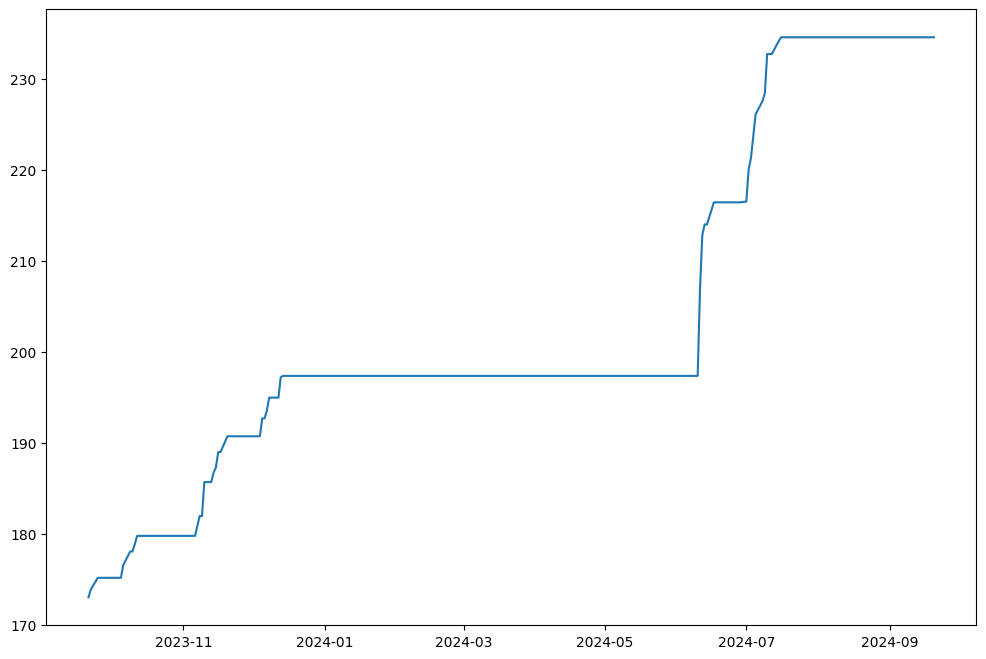

In [15]:
tk = tickers[0]
daily_drawdowns = pd.DataFrame(columns=tickers, index=df_adj_close.index)
max_daily_drawdowns = pd.DataFrame(columns=tickers, index=df_adj_close.index)
roll_max = pd.DataFrame(columns=tickers, index=df_adj_close.index)

start_date_plot = datetime(2001, 5, 23)
end_date_plot = datetime(2001, 9, 21)
window = 252  # a year
# window = 63    # a quarter
# NOTE: make window a user-input parameter and plot roll_max 

# roll_max[tk] = df_adj_close[tk].rolling(window, min_periods=1).max()

# NOTE: Specifying a window here does not seem to make much sense, since the recovery
# from each drawdown is not complete until a new rolling maximum appears, i.e. the first
# new value that exceeds the previous rolling max. By setting the window equal to the
# whole historical period of interest we obtain a monotonic function where each flat
# segment corresponds to a separate drawdown - but only if there is a drop in Adj Close
# within that segment; and each monotonically rising segment is a period between
# two consecutive drawdowns (i.e. a period where Adj Close is rising to a new rolling max
# until it is followed by a fall). Within each drawdown period the minimum in the original
# Adj Close curve defines the trough, number of days from start of drawdown to trough 
# defines the length of the To-Trough period, and number of days from trough to the last 
# day of the flat segment defines the length of the Recovery period.

roll_max[tk] = df_adj_close[tk].rolling(len(df_adj_close), min_periods=1).max()
roll_max.to_csv('../data/downloads/LP25_roll_max.csv')
daily_drawdowns[tk] = df_adj_close[tk] / roll_max[tk] - 1.0
max_daily_drawdowns[tk] = daily_drawdowns.rolling(window, min_periods=1).min()  # max negative

# display(roll_max)
# print(min(roll_max[tk]), max(roll_max[tk]))

# display(daily_drawdowns.loc[daily_drawdowns.index <= '2001-09-21'])
# print(min(daily_drawdowns[tk]), max(daily_drawdowns[tk]))

# display(max_daily_drawdowns.loc[max_daily_drawdowns.index <= '2001-09-21'])
# print(min(max_daily_drawdowns[tk]), max(max_daily_drawdowns[tk]))

plot_roll_max = plot_historical(tk, roll_max, start_date, end_date, title='Rolling Max')
plot_daily_drawdowns = plot_historical(tk, daily_drawdowns, start_date, end_date, y_max=0, title='Daily Drawdowns')
plot_max_daily_drawdowns = plot_historical(tk, max_daily_drawdowns, start_date, end_date, y_max=0, title='Max Daily Drawdowns')


In [11]:
unique_max_list = roll_max[tk].unique()
n_adj_close = len(df_adj_close)

# NOTE: It is convenient to define recovery as a situation where Adj Close is above the 
# rolling maximum, rather than no less than the rolling max, so that a single 
# segment does not accidentally include two drawdown periods starting with the same 
# rolling max. 
# NOTE: PROBLEM - Adj Close which is above rolling max belongs to the next segment already.
# Best to define next date in the index (recovery_date).
#
# NOTE: An elegant way of identifying drawdown periods is presented in this YT video
# https://www.youtube.com/watch?v=9tMk5Pmwhf8
# The first day's drawdown is set to 0; then on each subsequent day the it is calculated as
# min((1 + previous day's drawdown) * (1 + current day's return) - 1, 0)
# where current day's return = current day's price / previous day's price - 1
# If the drawdown at any day reaches zero, it signifies that a new maximum price (rolling max).
# The minimum (most negative) value between two zeros is the trough depth.


for mx in unique_max_list:
    
    cond = roll_max[tk] == mx
    seg = roll_max.loc[cond, tk]
    n_seg = len(seg)
    
    if n_seg > 2:
    
        min_date_seg = seg.index.min()
        max_date = seg.index.max()
        max_iloc = df_adj_close.index.get_loc(max_date)

        cond_below_max = df_adj_close[tk] < mx
        cond_in_range = (df_adj_close.index >= min_date_seg) & (df_adj_close.index <= max_date) & cond_below_max

        min_date = df_adj_close.loc[cond_in_range].index.min()
        min_iloc = df_adj_close.index.get_loc(min_date)
        peak_date = min_date if min_iloc == 0 else df_adj_close.index[min_iloc - 1]
        # https://stackoverflow.com/questions/43482549/get-previous-and-next-index-values-in-dataframe-should-they-exist

        trough = df_adj_close.loc[cond_in_range, tk].min()
        cond_trough = cond_in_range & (df_adj_close[tk] == trough)
        trough_date = df_adj_close[cond_trough].index[0]

        recovery_date = max_date if max_iloc == n_adj_close else df_adj_close.index[max_iloc + 1]
        # Adding condition for Adj Close to be lower than rolling max in case the segment
        # starts with a flat part, in which case the last date of the flat part is the min_date.
        # Then just add 1 to the length of the To Trough period calculated based on the condition below.
        # Similarly if the last Adj Close of the segment is the same as the first one, then it will be
        # skipped, and 1 will be added to the length of the Recovery period.
        # NOTE: Must adjust the dates, too, as they will also be reported.

        # NOTE: If the last Adj Close in the last segment is less than that segment's rolling max, then 
        # there was no recovery in that segment. It should still be reported if the drawdown in that segment is
        # significant, must marked somehow to indicate no recovery (e.g. as 0 or -1)

        cond_to_trough = (df_adj_close.index >= min_date) & (df_adj_close.index <= trough_date)  & cond_below_max
        cond_recovery = (df_adj_close.index > trough_date) & (df_adj_close.index <= max_date)  & cond_below_max
        n_to_trough = len(seg[cond_to_trough]) + 1
        n_recovery = len(seg[cond_recovery]) + 1
        n_length = n_to_trough + n_recovery
        drawdown = trough / mx - 1
        # print(f'{mx}:\t{min_date}\t{trough_date}\t{max_date}\t{drawdown:.6f}\t{n_length}\t{n_to_trough}\t{n_recovery}')
        print(f'{mx}:\t{peak_date}\t{trough_date}\t{recovery_date}\t{drawdown:.6f}\t{n_length}\t{n_to_trough}\t{n_recovery}')


99.81:	2000-01-03	2000-01-06	2000-01-17	-0.016832	11	4	7
99.91:	2000-01-17	2000-02-22	2000-03-17	-0.016615	45	27	18
100.57:	2000-03-22	2000-05-22	2000-07-11	-0.017202	80	44	36
101.03:	2000-07-13	2000-07-18	2000-07-20	-0.001485	6	4	2
101.11:	2000-07-20	2000-07-28	2000-08-04	-0.007022	12	7	5
102.51:	2000-08-23	2000-08-24	2000-08-28	-0.001463	4	2	2
102.55:	2000-08-29	2000-08-30	2000-08-31	-0.000098	3	2	1
102.98:	2000-09-05	2000-10-12	2001-02-06	-0.020975	111	28	83
103.14:	2001-02-06	2001-03-22	2001-05-10	-0.031026	68	33	35
103.15:	2001-05-10	2001-05-14	2001-05-17	-0.003684	6	3	3
103.69:	2001-05-22	2001-09-21	2003-07-14	-0.084290	560	89	471
103.79:	2003-07-14	2003-08-06	2003-08-21	-0.018306	29	18	11
104.07:	2003-08-22	2003-08-29	2003-09-08	-0.003555	12	6	6
104.08:	2003-09-08	2003-09-09	2003-09-12	-0.000576	4	2	2
105.14:	2003-09-18	2003-09-30	2003-11-03	-0.017405	33	9	24
105.36:	2003-11-03	2003-11-20	2003-12-18	-0.009871	34	14	20
105.71:	2003-12-23	2003-12-24	2003-12-29	-0.001324	5	2	3
105.

In [12]:
def summarize_tk_drawdowns(df, tk, sort_by, n_top=5):
    """
    df:         input dataframe of historical prices, such as df_adj_close
    tk:         ticker for which to perform the analysis
    sort_by:    column to sort by, should be a based on user input
    n_top:      number of top drawdowns to include in df_tk_deepest_drawdowns
    return:     drawdown_data = {
                    'Drawdown Stats': df_tk_drawdowns,
                    'Deepest Drawdowns': df_tk_deepest_drawdowns,
                    'Longest Drawdowns': df_tk_longest_drawdowns
                }
    """

    df_roll_max = pd.DataFrame(index=df.index)
    drawdown_columns = [
        'Peak',
        'Trough',
        '% Drawdown',
        'Peak Date',
        'Trough Date',
        'Recovery Date',
        'Total Length',
        'Peak To Trough',
        'Trough To Recovery'
    ]
    cols_float = [
        'Peak',
        'Trough',
        '% Drawdown'
    ]
    cols_int = [
        'Total Length',
        'Peak To Trough',
        'Trough To Recovery'
    ]
    cols_str = [
        'Peak Date',
        'Trough Date',
        'Recovery Date'
    ]
    
    df_tk_drawdowns = pd.DataFrame(columns=drawdown_columns)
    df_tk_deepest_drawdowns = pd.DataFrame(columns=drawdown_columns)
    df_tk_longest_drawdowns = pd.DataFrame(columns=drawdown_columns)
    
    n = len(df)
    df_roll_max[tk] = df[tk].rolling(n, min_periods=1).max()
    unique_max_list = df_roll_max[tk].unique()
    
    for peak in unique_max_list:
    
        # Define a segment corresponding to vmax 
        cond = df_roll_max[tk] == peak
        seg = df_roll_max.loc[cond, tk]
        n_seg = len(seg)

        # There was no drop within a segment if its length is 1 or 2
        if n_seg > 2:

            # The first date of the segment (min_date_seg) may not necessarily be the first date of the drawdown; e.g. 
            # if the segment starts with a flat section. In that case the last date of the flat part becomes the min_date.

            min_date_seg = seg.index.min()
            max_date = seg.index.max()
            max_iloc = df_adj_close.index.get_loc(max_date)

            cond_below_max = df_adj_close[tk] < peak
            cond_in_range = (df_adj_close.index >= min_date_seg) & (df_adj_close.index <= max_date) & cond_below_max

            min_date = df_adj_close.loc[cond_in_range].index.min()
            min_iloc = df_adj_close.index.get_loc(min_date)
            peak_date = min_date if min_iloc == 0 else df_adj_close.index[min_iloc - 1]
            
            trough = df_adj_close.loc[cond_in_range, tk].min()
            cond_trough = cond_in_range & (df_adj_close[tk] == trough)
            trough_date = df_adj_close[cond_trough].index[0]
            recovery_date = max_date if max_iloc == n_adj_close else df_adj_close.index[max_iloc + 1]

            # NOTE: If the last Adj Close in the last segment is less than that segment's rolling max, then 
            # there was no recovery in that segment. It should still be reported if the drawdown in that segment is
            # significant, must marked somehow to indicate no recovery (e.g. as 0 or -1)

            cond_to_trough = (df_adj_close.index >= min_date) & (df_adj_close.index <= trough_date) & cond_below_max
            cond_recovery = (df_adj_close.index > trough_date) & (df_adj_close.index <= max_date) & cond_below_max
            n_to_trough = len(seg[cond_to_trough]) + 1
            n_recovery = len(seg[cond_recovery]) + 1
            n_length = n_to_trough + n_recovery
            drawdown = trough / peak - 1

            df_tk_drawdowns.loc[peak, 'Peak'] = peak
            df_tk_drawdowns.loc[peak, 'Trough'] = trough
            df_tk_drawdowns.loc[peak, 'Peak Date'] = peak_date
            df_tk_drawdowns.loc[peak, 'Trough Date'] = trough_date
            df_tk_drawdowns.loc[peak, 'Recovery Date'] = recovery_date
            df_tk_drawdowns.loc[peak, '% Drawdown'] = 100 * drawdown
            df_tk_drawdowns.loc[peak, 'Total Length'] = n_length
            df_tk_drawdowns.loc[peak, 'Peak To Trough'] = n_to_trough
            df_tk_drawdowns.loc[peak, 'Trough To Recovery'] = n_recovery

    ascending = True if df_tk_drawdowns[sort_by].mean() < 0 else False
    df_tk_drawdowns = df_tk_drawdowns.sort_values(by=sort_by, ascending=ascending)
    df_tk_drawdowns = df_tk_drawdowns.reset_index(drop=True)

    for col in cols_float:
        df_tk_drawdowns[col] = df_tk_drawdowns[col].astype(float)
    for col in cols_int:
        df_tk_drawdowns[col] = df_tk_drawdowns[col].astype(int)
    for col in cols_str:
        df_tk_drawdowns[col] = df_tk_drawdowns[col].astype(str)

    df_tk_deepest_drawdowns = df_tk_drawdowns.sort_values(by='% Drawdown', ascending=True)
    df_tk_deepest_drawdowns = df_tk_deepest_drawdowns.reset_index(drop=True)[:n_top]
 
    df_tk_longest_drawdowns = df_tk_drawdowns.sort_values(by='Total Length', ascending=False)
    df_tk_longest_drawdowns = df_tk_longest_drawdowns.reset_index(drop=True)[:n_top]

    drawdown_data = {
        'Drawdown Stats': df_tk_drawdowns,
        'Deepest Drawdowns': df_tk_deepest_drawdowns,
        'Longest Drawdowns': df_tk_longest_drawdowns
    }

    return drawdown_data

# Assume user's input for the number of top drawdowns
n_top = 8

tk = tickers[0]
# sort_by = 'Total Length'
sort_by = '% Drawdown'
drawdown_data = summarize_tk_drawdowns(df_adj_close, tk, sort_by, n_top)
df_tk_drawdowns = drawdown_data['Drawdown Stats']
df_tk_deepest_drawdowns = drawdown_data['Deepest Drawdowns']
df_tk_longest_drawdowns = drawdown_data['Longest Drawdowns']  # make it largest total period 

# display(df_tk_drawdowns)
display(df_tk_deepest_drawdowns)
display(df_tk_longest_drawdowns)

# print(df_tk_drawdowns.dtypes)

,Peak,Trough,% Drawdown,Peak Date,Trough Date,Recovery Date,Total Length,Peak To Trough,Trough To Recovery
0,103.69,94.95,-8.428971,2001-05-22,2001-09-21,2003-07-14,560,89,471
1,124.03,119.25,-3.853906,2006-02-22,2006-06-13,2006-09-01,138,80,58
2,103.14,99.94,-3.102579,2001-02-06,2001-03-22,2001-05-10,68,33,35
3,109.81,106.43,-3.078044,2004-03-08,2004-06-14,2004-11-12,180,71,109
4,102.98,100.82,-2.097495,2000-09-05,2000-10-12,2001-02-06,111,28,83
5,103.79,101.89,-1.830620,2003-07-14,2003-08-06,2003-08-21,29,18,11
6,121.05,118.85,-1.817431,2005-10-03,2005-10-28,2005-11-24,39,20,19
7,105.14,103.31,-1.740536,2003-09-18,2003-09-30,2003-11-03,33,9,24


,Peak,Trough,% Drawdown,Peak Date,Trough Date,Recovery Date,Total Length,Peak To Trough,Trough To Recovery
0,103.69,94.95,-8.428971,2001-05-22,2001-09-21,2003-07-14,560,89,471
1,109.81,106.43,-3.078044,2004-03-08,2004-06-14,2004-11-12,180,71,109
2,124.03,119.25,-3.853906,2006-02-22,2006-06-13,2006-09-01,138,80,58
3,102.98,100.82,-2.097495,2000-09-05,2000-10-12,2001-02-06,111,28,83
4,100.57,98.84,-1.720195,2000-03-22,2000-05-22,2000-07-11,80,44,36
5,103.14,99.94,-3.102579,2001-02-06,2001-03-22,2001-05-10,68,33,35
6,99.91,98.25,-1.661495,2000-01-17,2000-02-22,2000-03-17,45,27,18
7,114.12,112.36,-1.542236,2005-02-11,2005-02-23,2005-04-13,44,9,35


In [13]:
def map_values(k_list, v_min, v_max, ascending=False):
    """
    Maps numbers from k_list to proportionally spaced values between v_min and v_max.
    Returns a dictionary of k_list elements as keys and the mapped values.
    k_list:     input list of n numerical elements that will serve as dictionary keys
    v_min:      lower bound of mapped values
    v_max:      upper bound of mapped values
    ascending:  a flag indicating whether the order of elements in k_list is ascending or descending
    """
    dict_map = {}
    k_list = sorted(k_list)
    if ascending:
        k_list.reverse()
    k_first = k_list[0]
    k_last = k_list[len(k_list) - 1]
    dict_map.update({k_first: v_min, k_last: v_max})

    k_range = k_last - k_first
    v_range = v_max - v_min
    kv_scale = v_range / k_range

    for k in k_list[1: -1]:
        k_delta = k - k_first
        v = v_min + k_delta * kv_scale
        dict_map.update({k: v})
    
    return dict_map

Top Drawdowns Plot - Matplotlib

x_min = 2000-01-04 (type <class 'str'>), x_max = 2006-09-01 (type <class 'str'>)
y_min = 90 (type <class 'int'>), y_max = 125 (type <class 'int'>)


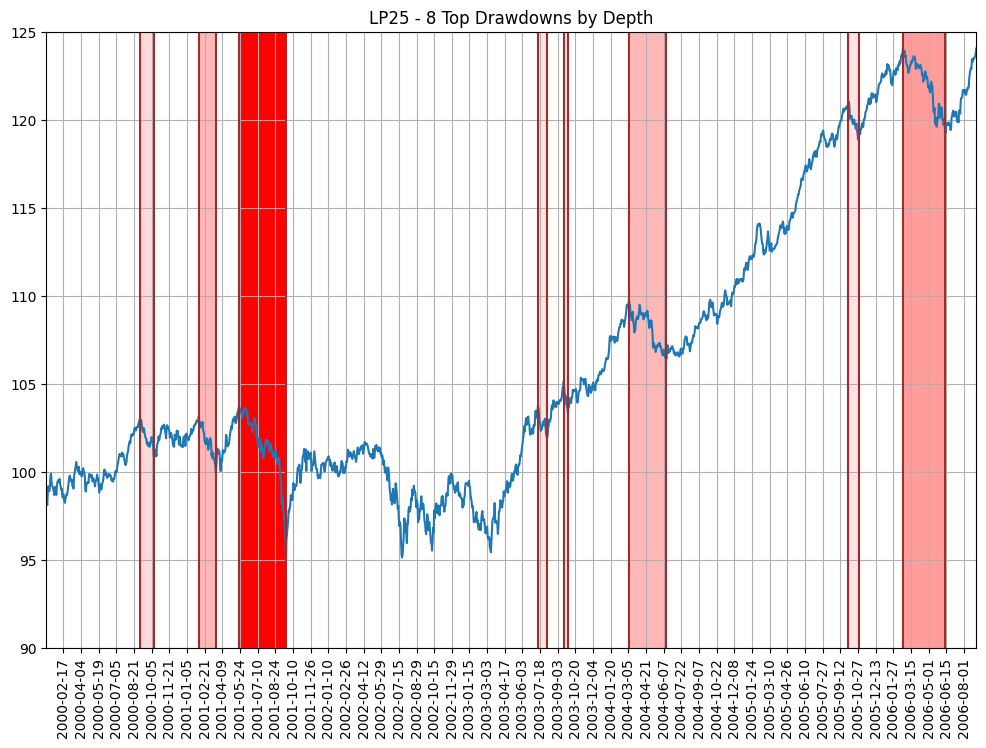

In [14]:
y_min, y_max = 90, 125
# y_min, y_max = 100, 104

# end_date = datetime(2006, 9, 4)    # Wurtz p. 35, example for 'LP25'
# start_date = datetime(2000, 1, 4)  # Wurtz p. 35, example for 'LP25'

# start_date = datetime(2001, 1, 1)
# end_date = datetime(2003, 9, 1)

top_by = 'depth'  # or 'length' - user input
# top_by = 'length'
top_by_color = 'red'

show_trough_to_recovery = False  # based on user input, force it to True if top_by == 'length'
# show_trough_to_recovery = True

title_drawdowns = f'LP25 - {n_top} Top Drawdowns by {top_by.capitalize()}'

plot_lp25_drawdowns = plot_historical(
    tk,
    df_adj_close,
    start_date,
    end_date,
    title=title_drawdowns,
    y_min=y_min,
    y_max=y_max
)

alpha_min, alpha_max = 0.1, 1  # colour intensity between 0 and 1

if top_by == 'depth':

    deepest_list = list(df_tk_deepest_drawdowns['% Drawdown'])
    deepest_cmap = map_values(deepest_list, alpha_min, alpha_max, ascending=True)

    for i, x0, x1, x2, depth, length in zip(
            df_tk_deepest_drawdowns.index,
            df_tk_deepest_drawdowns['Peak Date'],
            df_tk_deepest_drawdowns['Trough Date'],
            df_tk_deepest_drawdowns['Recovery Date'],
            df_tk_deepest_drawdowns['% Drawdown'],
            df_tk_deepest_drawdowns['Total Length']
    ):
        alpha_deepest = deepest_cmap[depth]
        plt.axvline(x0, color='brown')
        plt.axvline(x1, color='brown')
        plt.axvspan(x0, x1, color=top_by_color, alpha=alpha_deepest, lw=0)  # lw = lineweight, better to add contrasting lines via axvline
        if show_trough_to_recovery:
            plt.axvline(x2, color='brown')
            plt.axvspan(x1, x2, color=top_by_color, alpha=alpha_deepest, lw=0)

else:
    
    longest_list = list(df_tk_longest_drawdowns['Total Length'])
    longest_cmap = map_values(longest_list, alpha_min, alpha_max, ascending=False)
    
    for i, x0, x1, x2, length in zip(
        df_tk_longest_drawdowns.index,
        df_tk_longest_drawdowns['Peak Date'],
        df_tk_longest_drawdowns['Trough Date'],
        df_tk_longest_drawdowns['Recovery Date'],
        df_tk_longest_drawdowns['Total Length']
    ):
        alpha_longest = longest_cmap[length]
        plt.axvline(x0, color='brown')
        plt.axvline(x1, color='brown')
        plt.axvline(x2, color='brown')
        plt.axvspan(x0, x2, color=top_by_color, alpha=alpha_longest, lw=0)


Top Drawdown plot - Plotly

In [15]:
# For plotly color definitions see
# https://github.com/plotly/plotly.py/blob/master/packages/python/plotly/templategen/utils/colors.py

plotly_layout = go.Layout(template='plotly_dark')
# plotly_layout = go.Layout(template='plotly_white')
print(plotly_layout.template.layout.xaxis)

layout.XAxis({
    'automargin': True,
    'gridcolor': '#283442',
    'linecolor': '#506784',
    'ticks': '',
    'title': {'standoff': 15},
    'zerolinecolor': '#283442',
    'zerolinewidth': 2
})


In [16]:
display(df_adj_close.index)

Index(['2000-01-03', '2000-01-04', '2000-01-05', '2000-01-06', '2000-01-07',
       '2000-01-10', '2000-01-11', '2000-01-12', '2000-01-13', '2000-01-14',
       ...
       '2006-08-21', '2006-08-22', '2006-08-23', '2006-08-24', '2006-08-25',
       '2006-08-28', '2006-08-29', '2006-08-30', '2006-08-31', '2006-09-01'],
      dtype='object', name='Date', length=1740)

In [17]:
selected_template = 'plotly_dark'
selected_layout = go.Layout(template=selected_template)
if selected_template == 'plotly_dark':
    linecolor = 'deepskyblue'
    x_gridcolor = selected_layout.template.layout.xaxis['gridcolor']
    y_gridcolor = selected_layout.template.layout.yaxis['gridcolor']
    x_linecolor = selected_layout.template.layout.xaxis['linecolor']
    y_linecolor = selected_layout.template.layout.yaxis['linecolor']
else:
    linecolor = '#1f77b4'  # 'tab: blue'
    x_gridcolor, y_gridcolor = 'black', 'black'
    x_linecolor, y_linecolor = 'black', 'black'
    
title_font_size = 32

top_by = 'depth'  # or 'length' - user input
# top_by = 'length'
top_by_color = 'red'

show_trough_to_recovery = False  # based on user input, force it to True if top_by == 'length'
# show_trough_to_recovery = True

tk = 'LP25'
title_drawdowns = f'{tk} - {n_top} Top Drawdowns by {top_by.capitalize()}'

fig = make_subplots(rows = 1, cols = 1)
df_tk = df_adj_close[tk]
min_y = min(df_tk)
max_y = max(df_tk)
# y_min, y_max = 90, 125
y_min, y_max = set_axis_limits(min_y, max_y)

n_ticks_max = 48

fig.add_trace(
    go.Scatter(
        x = df_adj_close.index,
        y = df_tk,
        showlegend = False
    )
)
# print(plotly_layout.xaxis)
for i, x0, x1, x2, depth, length in zip(
        df_tk_deepest_drawdowns.index,
        df_tk_deepest_drawdowns['Peak Date'],
        df_tk_deepest_drawdowns['Trough Date'],
        df_tk_deepest_drawdowns['Recovery Date'],
        df_tk_deepest_drawdowns['% Drawdown'],
        df_tk_deepest_drawdowns['Total Length']
):
    print(i, x0, x1, x2, depth, length)
    alpha_deepest = deepest_cmap[depth]
    fig.add_vline(
        x0,
        line_color = 'brown',
        layer = 'below'
    )
    fig.add_vline(
        x1,
        line_color = 'brown',
        layer = 'below'
    )
    fig.add_vrect(
        x0,
        x1,
        fillcolor = top_by_color,
        opacity = alpha_deepest,
        line_width = 0,
        layer = 'below'
    )
    if show_trough_to_recovery:
        fig.add_vline(
            x2,
            line_color = 'brown',
            layer = 'below'
        )
        fig.add_vrect(
            x1,
            x2,
            fillcolor = top_by_color,
            opacity = alpha_deepest,
            line_width = 0,
            layer = 'below'
        )
fig.add_trace(
    go.Scatter(
        x = df_adj_close.index,
        y = df_tk,
        line = dict(color = linecolor),
        # line = dict(color='deepskyblue'),
        # line = dict(color='#1f77b4'),  # tab:blue
        # fill = 'tozeroy',
        # fillcolor = '#1f77b4',
        name = 'Adjusted Close',
        showlegend = True
    )
)
fig.add_shape(
# Rectangle with reference to the plot
    type = 'rect',
    xref = 'paper',
    yref = 'paper',
    x0 = 0,
    y0 = 0,
    x1 = 1,
    y1 = 1,
    line_color = x_linecolor,
    # line_color = 'white',
    # line_color = '#506784',  # 'Rhino Dark', appears to be the default axis linecolor in plotly_dark
    # line_color = '#283442',  # 'Rhino Darker', appears to be the default axis gridcolor in plotly_dark
    # line_color = 'black',
    line_width = 0.3
)

fig.update_layout(
    width = 1450,
    height = 725,
    xaxis_rangeslider_visible = False,
    template = selected_template,
    # template = 'plotly_dark',
    # template = 'plotly',
    # template = 'plotly_white',  # plotly template is better
    yaxis_title = f'Adjusted Close',
    title = dict(
        text = title_drawdowns,
        font_size = title_font_size,
        y = 0.95,
        x = 0.45,
        xanchor = 'center',
        yanchor = 'top'
    )
)
fig.update_xaxes(
    # tickformat = "%Y-%m-%d",
    type = 'category',
    showgrid = True,
    # gridcolor = 'grey',
    nticks = n_ticks_max,
    tickangle = -90,
    ticks = 'outside',
    ticklen = 8,
    ticklabelshift = 5,  # not working
    ticklabelstandoff = 10  # not working
)
fig.update_yaxes(
    range = (y_min, y_max),
    showgrid = True,
    ticks = 'outside',
    ticklen = 8,
    ticklabelshift = 5,  # not working
    ticklabelstandoff = 20  # not working
)

fig.show()

# For details of default styles in each plotle template see
# https://github.com/plotly/plotly.py/blob/master/packages/python/plotly/templategen/definitions.py

0 2001-05-22 2001-09-21 2003-07-14 -8.428970971164041 560
1 2006-02-22 2006-06-13 2006-09-01 -3.8539063129887974 138
2 2001-02-06 2001-03-22 2001-05-10 -3.1025790188093927 68
3 2004-03-08 2004-06-14 2004-11-12 -3.0780438939987165 180
4 2000-09-05 2000-10-12 2001-02-06 -2.0974946591571286 111
5 2003-07-14 2003-08-06 2003-08-21 -1.830619520184995 29
6 2005-10-03 2005-10-28 2005-11-24 -1.8174308137133388 39
7 2003-09-18 2003-09-30 2003-11-03 -1.7405364276203095 33


In [18]:
import warnings
warnings.simplefilter('ignore', UserWarning)

Colors names: https://matplotlib.org/stable/gallery/color/named_colors.html

x_min = 2000-01-04 (type <class 'str'>), x_max = 2006-09-01 (type <class 'str'>)
y_min = 90.0 (type <class 'numpy.float64'>), y_max = 125.0 (type <class 'numpy.float64'>)
plot_lp25:	<class 'tuple'>
plot_sma_60:	<class 'list'>
plot_ema_60:	<class 'list'>
x_min = 2000-01-04 (type <class 'str'>), x_max = 2006-09-01 (type <class 'str'>)
y_min = 95.0 (type <class 'numpy.float64'>), y_max = 125.0 (type <class 'numpy.float64'>)
-1.0 0.6


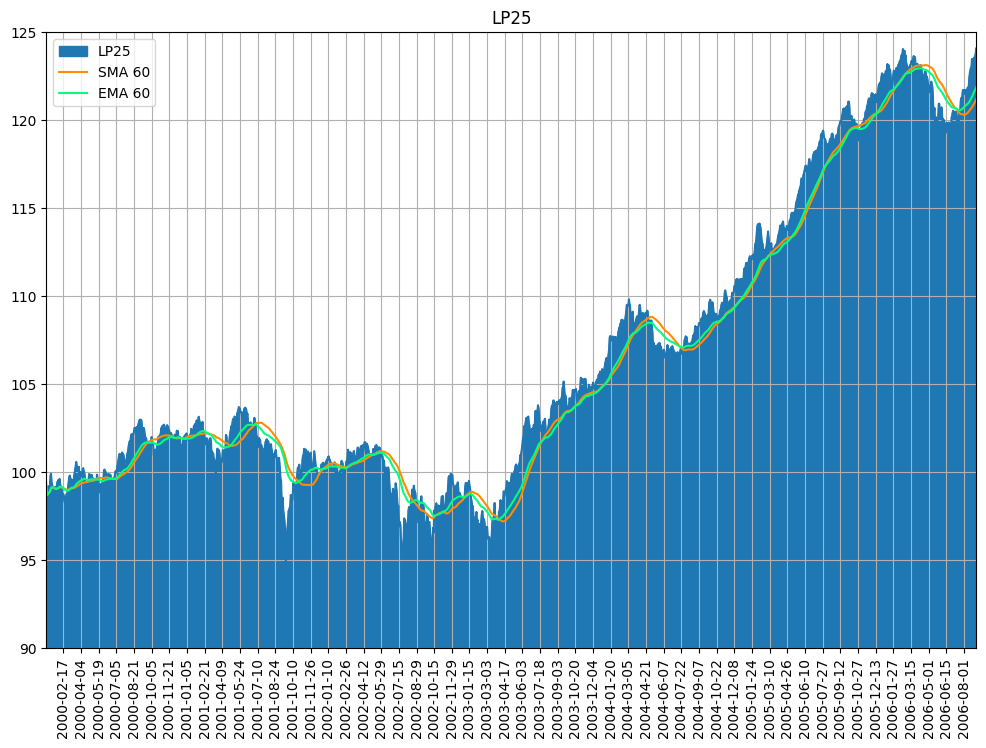

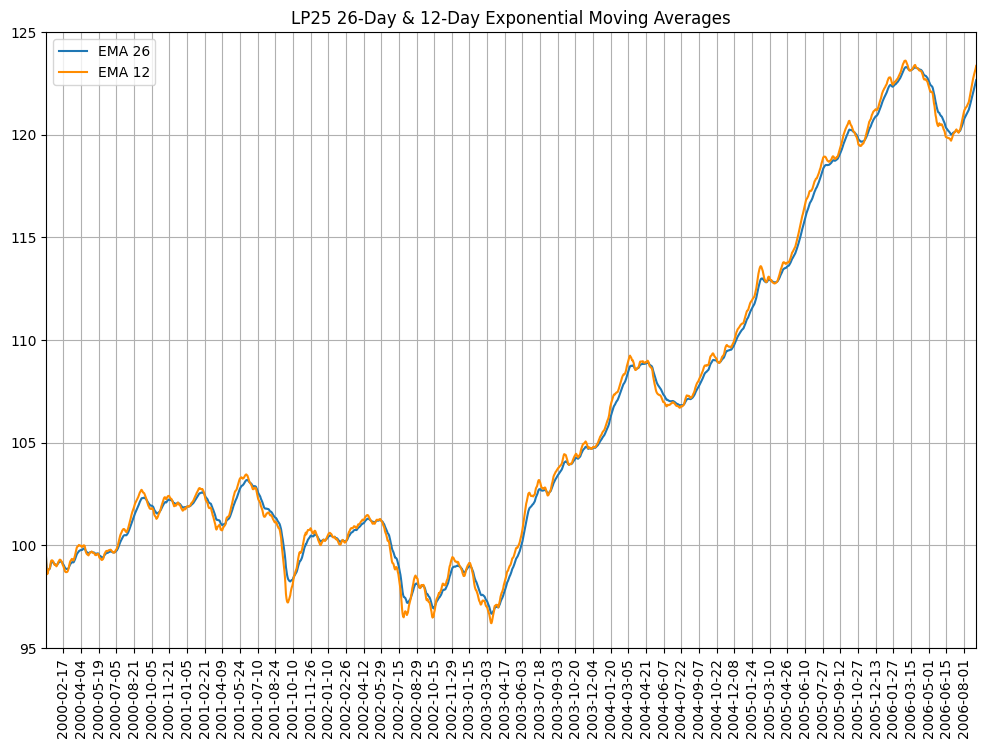

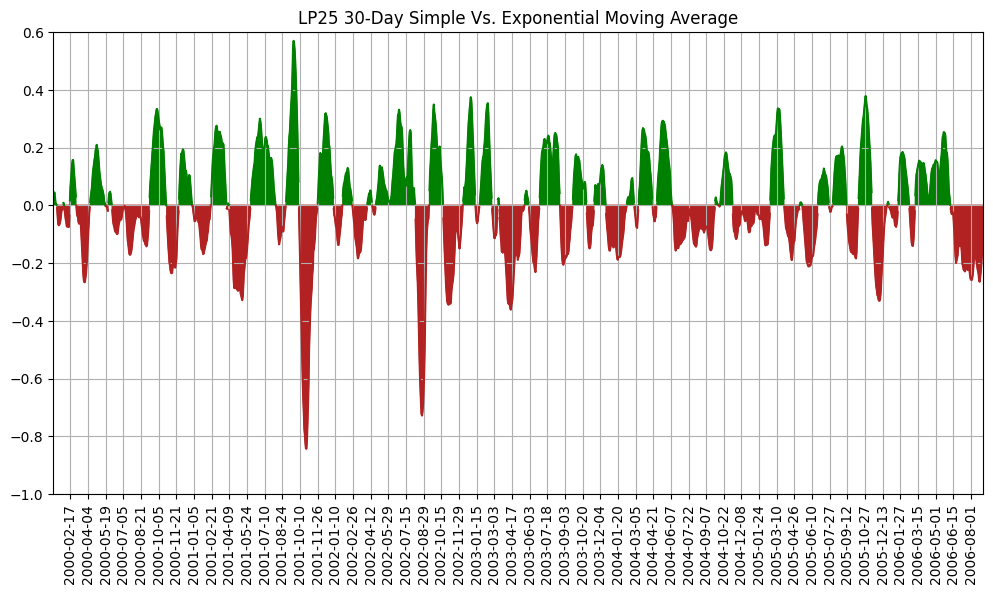

In [19]:
y_min, y_max = 90, 125
# y_min, y_max = 100, 104

end_date = datetime(2006, 9, 4)    # Wurtz p. 35, example for 'LP25'
start_date = datetime(2000, 1, 4)  # Wurtz p. 35, example for 'LP25'|

# start_date = datetime(2001, 1, 1)
# end_date = datetime(2003, 9, 1)

title = f'LP25'

df_tk = df_adj_close[tk]

# plot_lp25, = plot_historical(tk, df_adj_close, start_date, end_date, title=title, y_min=y_min, y_max=y_max)
plot_lp25 = plot_historical(tk, df_tk, start_date, end_date, fill=True)

df_sma_15 = df_tk.rolling(window=15, min_periods=1).mean()
df_sma_30 = df_tk.rolling(window=30, min_periods=1).mean()
df_sma_60 = df_tk.rolling(window=60, min_periods=1).mean()
# df_ema_30 = df_adj_close.rolling(window=30, min_periods=1).ewm(com=0.5).mean()
df_ema_15 = df_tk.ewm(span=15).mean()
df_ema_30 = df_tk.ewm(span=30).mean()
df_ema_60 = df_tk.ewm(span=60).mean()

# plt.plot(df_adj_close.index, df_sma_15, label='SMA 15 Days')
# plt.plot(df_adj_close.index, df_sma_30, label='SMA 30 Days')
plot_sma_60 = plt.plot(df_tk.index, df_sma_60, label='SMA 60 Days', color='darkorange')
# plt.plot(df_adj_close.index, df_ema_15, label='EMA Span 15')
# plt.plot(df_adj_close.index, df_ema_30, label='EMA Span 30')
plot_ema_60 = plt.plot(df_tk.index, df_ema_60, label='EMA Span 60', color='springgreen')
# plt.legend(labels=['LP25', 'SMA 15 Days', 'SMA 30 Days', 'SMA 60 Days'])
# plt.legend(labels=['LP25', 'SMA 15 Days', 'SMA 30 Days', 'EMA Decay 0.8'])
# plt.legend(labels=['LP25', 'SMA 30', 'EMA 30'])
print(f'plot_lp25:\t{type(plot_lp25)}')
print(f'plot_sma_60:\t{type(plot_sma_60)}')
print(f'plot_ema_60:\t{type(plot_ema_60)}')
# plt.legend(handles=[plot_lp25, plot_sma_60, plot_ema_60], labels=['LP25', 'SMA 60', 'EMA 60'])
plt.legend(labels=['_LP25', 'LP25', 'SMA 60', 'EMA 60'])  # label starting with underscore will be excluded from the legend

color_positive = 'green'
# color_negative = '#d62728'  # dark red, lighter than 'darkred'
color_negative = 'firebrick'

df_ema_26 = df_tk.ewm(span=26).mean()
df_ema_12 = df_tk.ewm(span=12).mean()
title_ema_26_12 = f'{tk} 26-Day & 12-Day Exponential Moving Averages'
plot_ema_26_12 = plot_historical(tk, df_ema_26, start_date, end_date, title_ema_26_12)
plt.plot(df_tk.index, df_ema_12, label='EMA Span 60', color='darkorange')
plt.legend(labels=['EMA 26', 'EMA 12'])

df_sma_ema_30 = df_sma_30 - df_ema_30
title_sma_ema_30 = 'LP25 30-Day Simple Vs. Exponential Moving Average'
plot_sma_ema_30 = plot_historical_2colors(
    tk,
    df_sma_ema_30,
    start_date,
    end_date,
    title_sma_ema_30,
    color_positive=color_positive,
    color_negative=color_negative,
    fill_positive=True,
    fill_negative=True,
    y_dim=6)


MACD

The moving average convergence divergence (MACD) is calculated by subtracting a 26-day exponential moving average from a 12-day exponential moving average.

start_date is NOT in df_macd.index
end_date is NOT in df_macd.index
2002-06-03 2002-11-29
-1.3213817389277551 0.8607653882848751
-1.5 1.0
-1.5 1.0


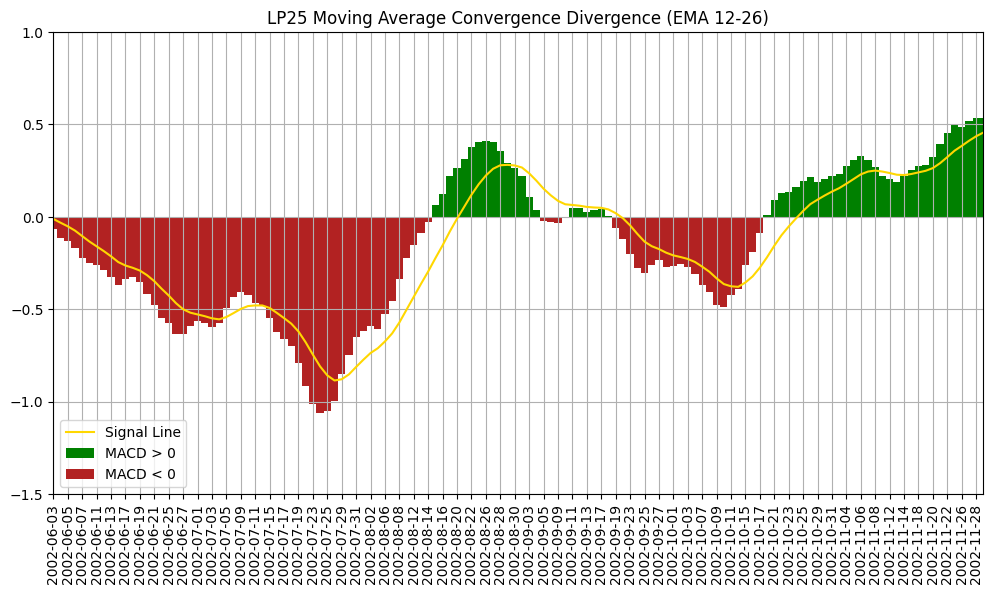

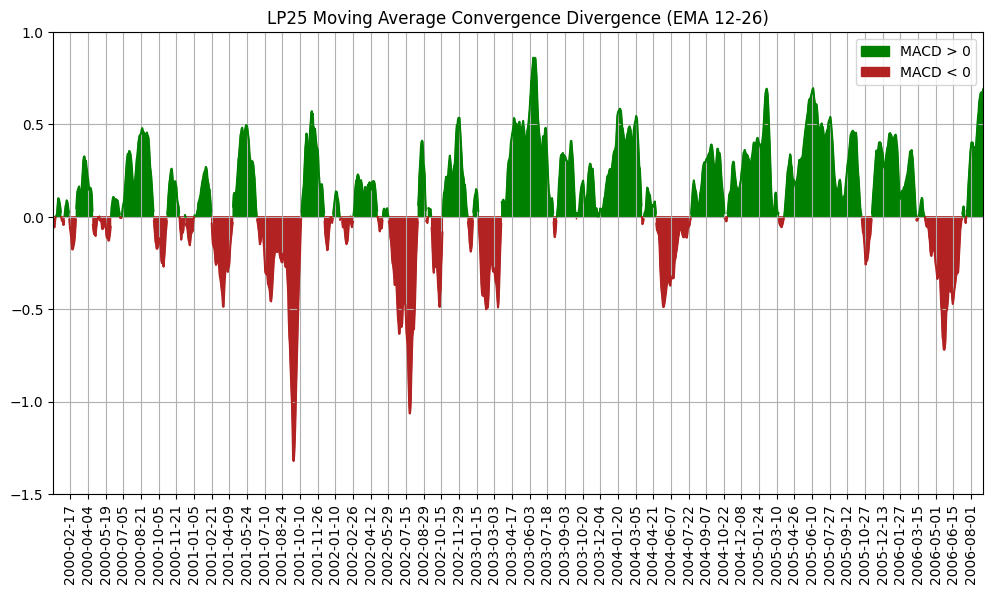

In [20]:
df_macd = df_ema_12 - df_ema_26
df_macd_signal = df_macd.ewm(span=9).mean()
title_macd = f'{tk} Moving Average Convergence Divergence (EMA 12-26)'

start_date_macd = start_date
end_date_macd = end_date
start_date_macd = datetime(2002, 6, 1)
end_date_macd = datetime(2002, 12, 1)
start_date_macd_str = str(start_date_macd.date())
end_date_macd_str = str(end_date_macd.date())

if start_date_macd_str not in df_macd.index:
    print('start_date is NOT in df_macd.index')
    while start_date_macd_str not in df_macd.index:
        start_date_macd += timedelta(1)
        start_date_macd_str = str(start_date_macd.date())

if end_date_macd_str not in df_macd.index:
    print('end_date is NOT in df_macd.index')
    while end_date_macd_str not in df_macd.index:
        end_date_macd += timedelta(-1)
        end_date_macd_str = str(end_date_macd.date())

print(start_date_macd_str, end_date_macd_str)
print(min(df_macd), max(df_macd))

signal_color = 'gold'
plot_type = 'bar'
add_signal_line = True
plot_macd = plot_historical_2colors(
    tk,
    df_macd,
    start_date_macd,
    end_date_macd,
    title_macd,
    plot_type=plot_type,
    color_positive=color_positive,
    color_negative=color_negative,
    fill_positive=True,
    fill_negative=True,
    y_dim=6)
if add_signal_line:
    plt.plot(df_macd_signal.index, df_macd_signal, label='MACD Signal Line', color=signal_color)
if plot_type == 'bar':
    if add_signal_line:
        plt.legend(['Signal Line', 'MACD > 0', 'MACD < 0'])
    else:
        plt.legend(['MACD > 0', 'MACD < 0'])
else:
    if add_signal_line:
        plt.legend(['_', 'MACD > 0', '_', 'MACD < 0', 'Signal Line'])
    else:
        plt.legend(['_', 'MACD > 0', '_', 'MACD < 0'])

plot_type = 'line'
add_signal_line = False
plot_macd = plot_historical_2colors(
    tk,
    df_macd,
    start_date,
    end_date,
    title_macd,
    plot_type=plot_type,
    color_positive=color_positive,
    color_negative=color_negative,
    fill_positive=True,
    fill_negative=True,
    y_dim=6)
if add_signal_line:
    plt.plot(df_macd_signal.index, df_macd_signal, label='MACD Signal Line', color=signal_color)
if plot_type == 'bar':
    if add_signal_line:
        plt.legend(['Signal Line', 'MACD > 0', 'MACD < 0'])
    else:
        plt.legend(['MACD > 0', 'MACD < 0'])
else:
    if add_signal_line:
        plt.legend(['_', 'MACD > 0', '_', 'MACD < 0', 'Signal Line'])
    else:
        plt.legend(['_', 'MACD > 0', '_', 'MACD < 0'])

1. Present drawdown summary for all user-selected tickers, containing:
>>- Top Drawdown by depth (in %)
>>- Top Drawdown by length (in days)
>>- Average Drawdown by depth (in %) - NOTE: it is common to include the zeros (periods between drawdowns) in this calculation - see https://www.youtube.com/watch?v=9tMk5Pmwhf8
>>- Ulcer Index (the square root of the average of the sum of the squared percentage drawdowns over a specific period of time - can be the whole historical period or a rolling 14-day)
>>- Calmar Ratio = Excess Return (Rp - Rf) / Max Drawdown (by depth)
>>- Sterling Ratio = Excess Return (Rp - Rf) / Average Drawdown (by depth)
>>- Martin Ratio = Excess Return (Rp - Rf) / Ulcer Index

>>Note that the mean historical drawdown differs from the average historical downturn because many drawdown periods contain multiple downturns between the peak and recovery.

2. Offer a more detailed drawdown analysis, including a table and a plot, for any single ticker, with the user being able to select:
>>- the number of top drawdowns
>>- whether the top drawdowns should be picked by depth or by length
>>- whether to show the trough-to-recovery phase in the plot